# Data Loading and Cleaning

In [1]:
# imports
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import os
import sklearn
import string as str
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [2]:
# Loading csv with preprocessed data
df = pd.read_csv('Preprocessed_data.csv')

# Cleaning the data
# Removing zero ratings
df = df[df['rating'] != 0]

In [3]:
# Removing image_url columns because we will not use it.
df = df.drop(['img_s'], axis=1)
df = df.drop(['img_m'], axis=1)
df = df.drop(['img_l'], axis=1)
df = df.dropna()
df = df.reset_index(drop=True)

In [4]:
df.head(5)

,Unnamed: 0,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,Summary,Language,Category,city,state,country
0,1,8,"timmins, ontario, canada",34.7439,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],timmins,ontario,canada
1,5,67544,"toronto, ontario, canada",30.0000,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],toronto,ontario,canada
2,9,123629,"kingston, ontario, canada",34.7439,0002005018,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],kingston,ontario,canada
3,11,200273,"comber, ontario, canada",34.7439,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],comber,ontario,canada
4,12,210926,"guelph, ontario, canada",34.7439,0002005018,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],guelph,ontario,canada


In [5]:
df.to_csv('Preprocessed_data_cleaned.csv', index=False)

In [6]:
# From now on we can work with df or load from the beggining 
# the Preprocessed_data_cleaned.csv file

-------------------------------------------------------------------
# Demographic Filtering

In [7]:
# Loading csv with book rating data
df_book_rating = pd.read_csv('BX-Book-Ratings.csv', sep=';',encoding= 'unicode_escape', engine='python')

#turns column to int
df_book_rating['Book-Rating']=[int(df_book_rating['Book-Rating'][rating].replace("'", '')) for rating in range(len(df_book_rating['Book-Rating']))]

# remove rows that have 0 as rating
df_book_rating = df_book_rating[df_book_rating['Book-Rating'] != 0]
df_book_rating=df_book_rating.reset_index(drop=True)
df_book_rating['ISBN']=[df_book_rating['ISBN'][rating].replace("'", '') for rating in range(len(df_book_rating['ISBN']))]

At this point we have cleaned and loaded the 2 dataframes that contain all the information we need to proceed.The 'Book-Ratings.csv' contains the ratings each user has appointed to books (the books are identified by ISBN). We will use this dataframe to calculate how many ratings each book has, as well as the average rating of each book. Also, we correlate these 2 values in a 'weighted rating score'. More specifically, this score takes into account both the number of ratings and the average rating. We chose the formula below, which is being used to calculate an according score for movies on IMDB website.

We will start using the weighted rating (WR) that IMDB is using, which is given as: 

Weighted Rating(WR)=(v/(v+m))*R)+((m/(v+m))*C)

where: 

* v is the number of votes per book
* m is the minimum votes required to be listed in the chart
* R is the average rating of the book
* C is the mean vote accrose the whole dataframe


In [8]:
#counts the number of ratings and puts them in to new dataframe
isbn_dict=Counter(df_book_rating['ISBN'])

df_isbn_votecount = pd.DataFrame(list(isbn_dict.items()), columns = ['ISBN', 'Vote-Count'])

The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 90th percentile as our cutoff. In other words, for a book to feature in the charts, it must have more votes than at least 90% of the booksin the list.

In [9]:
m= df_isbn_votecount['Vote-Count'].quantile(0.9)
isbn_votecount = df_isbn_votecount[df_isbn_votecount['Vote-Count'] >= m]
isbn_votecount=isbn_votecount.reset_index(drop=True)
print('The cut-off is {} and the cleaned dataframe contains {} rows.' .format(m,isbn_votecount.shape[0]))

The cut-off is 4.0 and the cleaned dataframe contains 19918 rows.


Now we will calculate the average rating of each book.

In [10]:
#merging the dataframes
df_custom_rating= pd.merge(isbn_votecount,df_book_rating, how='inner', on=['ISBN'])

#Crearing out the user column because we don't need it
df_custom_rating= df_custom_rating.drop(columns='User-ID')

#Calculates the mean value of all the row with the same ISBN, hence the average rating which is put to the column 'Vote-Average'
df_custom_rating['Vote-Average'] = df_custom_rating['Book-Rating'].groupby(df_custom_rating['ISBN']).transform('mean')

#Deletes the duplicates and 'Book-Rating' column because we do not need them
df_custom_rating =df_custom_rating.drop_duplicates(subset='ISBN', keep='first')
df_custom_rating =df_custom_rating.drop(['Book-Rating'], axis=1)

df_custom_rating.reset_index(drop=True)

,ISBN,Vote-Count,Vote-Average
0,3257224281,4,6.750000
1,038550120X,81,7.580247
2,0060517794,30,8.000000
3,0671537458,17,7.176471
4,0679776818,21,7.476190
...,...,...,...
19913,3250600571,4,9.000000
19914,0886775809,4,8.000000
19915,0375700110,4,6.500000
19916,0451450019,4,8.000000


Above we see the generated values for the average rating of each book. Now, it is time to calculate the weighted score mentioned before. For that we need the C value, which is the mean vote across the dataframe. Then we define a function according to the formula mentioned above and then we generate the weighted score for each book.

In [11]:
C= df_custom_rating['Vote-Average'].mean()
print('The value of C is: {}'.format(C))

#Weighted score function
def weighted_rating(x, m=m, C=C):
    v = x['Vote-Count']
    R = x['Vote-Average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C) ##maybe another function for books

df_custom_rating['Score']=weighted_rating(df_custom_rating, m=m, C=C)

df_custom_rating = df_custom_rating.sort_values('Score', ascending=False)
df_custom_rating

The value of C is: 7.653260512915471


,ISBN,Vote-Count,Vote-Average,Score
144901,0439425220,23,9.869565,9.541224
141498,0618002235,25,9.720000,9.434932
175300,0060256656,20,9.750000,9.400543
211100,0836213319,13,9.923077,9.389002
63913,8826703132,21,9.714286,9.384522
...,...,...,...,...
159321,3932069145,4,3.000000,5.326630
203380,1552781631,4,3.000000,5.326630
189493,349222539X,6,3.666667,5.261304
172663,1880985055,9,3.000000,4.431772


Above we see the generated values for the weighted score. It would be nice, however, if we could see which book they are refering to without having to search with the ISBN code. For this reason we add the 'BX_Books.csv as a dataframe, which contains the titles of the books according to their ISBN, amongst other information as well. With this dataframe we can link the title of each book and display it on the above dataframe.

In [12]:
books_df=pd.read_csv('BX_Books.csv', sep=';',encoding= 'unicode_escape', engine='python')

books_df = books_df.drop(columns=["Unnamed: 5",'Unnamed: 6', "Unnamed: 7","Unnamed: 8", "Unnamed: 9"])

#cleaning the punctuation off the words 
books_df["'ISBN'"]=[books_df["'ISBN'"][i].replace("'", '') for i in range(len(books_df["'ISBN'"]))]
books_df= books_df.rename(columns={"'ISBN'": 'ISBN', "'Book-Title'": 'Book-Title'})

#merging the information we need
intersection_df = pd.merge(books_df,df_custom_rating, how='inner', on=['ISBN'])
intersection_df = intersection_df.drop(columns=["'Book-Author'","'Year-Of-Publication'","'Publisher'"])

#passing the dataframe to csv so we can work with that later
intersection_df.to_csv('Books_Votes_Score.csv', index=False)

intersection_df = intersection_df.sort_values('Vote-Count', ascending=False)
intersection_df=intersection_df.reset_index(drop=True)
intersection_df

,ISBN,Book-Title,Vote-Count,Vote-Average,Score
0,0316666343,'The Lovely Bones: A Novel',707,8.185290,8.182297
1,0971880107,'Wild Animus',581,4.390706,4.413014
2,0385504209,'The Da Vinci Code',487,8.435318,8.428947
3,0312195516,'The Red Tent (Bestselling Backlist)',383,8.182768,8.177295
4,0060928336,'Divine Secrets of the Ya-Ya Sisterhood: A Novel',320,7.887500,7.884608
...,...,...,...,...,...
18695,0486280500,'A Portrait of the Artist As a Young Man (Dove...,4,7.250000,7.451630
18696,0140421998,'Leaves of Grass (Penguin Classics)',4,7.750000,7.701630
18697,0864425295,"'Brief Encounters: stories of love, sex & travel'",4,6.500000,7.076630
18698,0395401461,'Miss Nelson Is Missing!',4,7.500000,7.576630


In [13]:
intersection_df = intersection_df.sort_values('Score', ascending=False)
intersection_df=intersection_df.reset_index(drop=True)

[Text(0.5, 1.0, 'Top 10 recommended books ever!')]

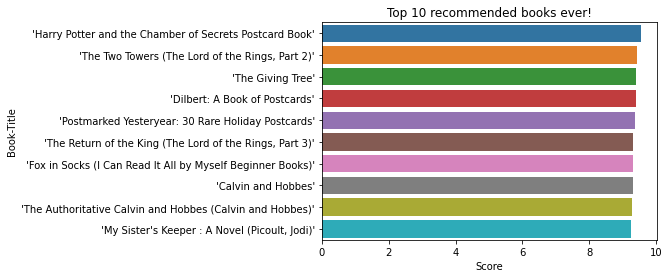

In [14]:
top_10= intersection_df.head(10)
sb.barplot(x = "Score", y = "Book-Title", data = top_10).set(title = "Top 10 recommended books ever!")

So, according to the users of this dataset, wherever you are from, make sure to read these books first!

### By country

Next we find the top books by country. Is essentially the same as above however we implement it by adding an extra column and joining the isbn with the country in order to create the popularity demographic diagrams.

In [15]:
# Loading csv with preprocessed data cleaned
df_cleaned = pd.read_csv('Preprocessed_data_cleaned.csv')


df_cleaned = df_cleaned[df_cleaned['country'] != ',']
df_cleaned = df_cleaned[df_cleaned['country'] != '\"n/a\""']
df_cleaned= df_cleaned.drop(columns=['user_id','Unnamed: 0','publisher','location','Language','Summary','year_of_publication','Category','city','state'])



df_cleaned['country']=df_cleaned['country'].str.split(',').str[-1]
df_cleaned['country']= df_cleaned['country'].replace(r' united kingdom',r'united kingdom')
df_cleaned['country']= df_cleaned['country'].replace(r'\"n/a\""',r'unknown')
df_cleaned= df_cleaned.sort_values(by=['country'],ascending=True)
df_cleaned=df_cleaned.reset_index(drop=True)
(df_cleaned['country']=='\"n/a\""').sum()
df_cleaned

,age,isbn,rating,book_title,book_author,country
0,33.0000,0140310657,10,The TV Kid (Puffin Books),Betsy Byars,australia
1,14.0000,0713100788,9,Discovering Greek Mythology (Woburn Educationa...,P. Kenneth Corsar,australia
2,33.0000,0140328262,10,The Paw Thing (Puffin Books),Paul Jennings,australia
3,13.0000,0340634448,5,The Cowboy Guide,Wayne Caba,australia
4,18.0000,0590454471,2,Picklemania (School Daze),Jerry Spinelli,australia
...,...,...,...,...,...,...
359445,21.0000,185326895X,8,Complete Works of William Shakespeare (Wordswo...,William Shakespeare,yugoslavia
359446,34.7439,0671000306,8,Shock Wave (Dirk Pitt Adventures (Paperback)),Clive Cussler,yugoslavia
359447,20.0000,0971880107,3,Wild Animus,Rich Shapero,yugoslavia
359448,55.0000,0671042858,7,The Girl Who Loved Tom Gordon,Stephen King,zambia


In [16]:
## The exact same process as 
df_cleaned['isbn-country'] = df_cleaned[['isbn', 'country']].agg('-'.join, axis=1)

In [17]:
#counts the number of ratings in each country and puts them in to new dataframe

isbn_dict1=Counter(df_cleaned['isbn-country'])

df_cleaned_isbn_votecount = pd.DataFrame(list(isbn_dict1.items()), columns = ['isbn-country', 'Vote-Count'])

In [18]:
m= df_cleaned_isbn_votecount['Vote-Count'].quantile(0.9)
isbn_votecount_bycountry = df_cleaned_isbn_votecount[df_cleaned_isbn_votecount['Vote-Count'] >= m]
isbn_votecount_bycountry=isbn_votecount_bycountry.reset_index(drop=True)
print('The cut-off is {} and the cleaned dataframe contains {} rows.' .format(m,isbn_votecount_bycountry.shape[0]))

The cut-off is 3.0 and the cleaned dataframe contains 23448 rows.


In [19]:
#merging the dataframes
df_rating_bycountry= pd.merge(isbn_votecount_bycountry,df_cleaned, how='inner', on=['isbn-country'])

#Calculates the mean value of all the row with the same ISBN, hence the average rating which is put to the column 'Vote-Average'
df_rating_bycountry['Vote-Average-By-Country'] = df_rating_bycountry['rating'].groupby(df_rating_bycountry['isbn-country']).transform('mean')

#Deletes the duplicates and 'Book-Rating' column because we do not need them
df_rating_bycountry =df_rating_bycountry.drop_duplicates(subset='isbn-country', keep='first')
df_rating_bycountry =df_rating_bycountry.drop(['rating'], axis=1)

df_rating_bycountry.reset_index(drop=True)

,isbn-country,Vote-Count,age,isbn,book_title,book_author,country,Vote-Average-By-Country
0,0091842050-australia,7,13.0000,0091842050,The Blue Day Book: A Lesson in Cheering Yourse...,Bradley Trevor Greive,australia,9.000000
1,0684872153-australia,3,29.0000,0684872153,Angela's Ashes (MMP) : A Memoir,Frank McCourt,australia,6.333333
2,0452282152-australia,7,34.7439,0452282152,Girl with a Pearl Earring,Tracy Chevalier,australia,9.285714
3,0552998486-australia,9,17.0000,0552998486,Chocolat,Joanne Harris,australia,8.222222
4,0099740516-australia,5,39.0000,0099740516,Fall on Your Knees,Ann-Marie MacDonald,australia,7.200000
...,...,...,...,...,...,...,...,...
23443,0684865114-usa,7,34.7439,0684865114,The Restraint of Beasts,Magnus Mills,usa,7.428571
23444,0553577905-usa,3,19.0000,0553577905,Windhaven,George R. R. Martin,usa,7.000000
23445,0451402391-usa,6,34.7439,0451402391,The Search for the Green River Killer,Carlton Smith,usa,8.166667
23446,0060393823-usa,8,34.7439,0060393823,Lost,Gregory Maguire,usa,6.125000


In [20]:
C= df_rating_bycountry['Vote-Average-By-Country'].mean()
print('The value of C is: {}'.format(C))

#Weighted score function
def weighted_rating(x, m=m, C=C):
    v = x['Vote-Count']
    R = x['Vote-Average-By-Country']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C) ##maybe another function for books

df_rating_bycountry['Score']=weighted_rating(df_rating_bycountry, m=m, C=C)

df_rating_bycountry = df_rating_bycountry.sort_values('Score', ascending=False)
df_rating_bycountry

The value of C is: 7.672355126591286


,isbn-country,Vote-Count,age,isbn,book_title,book_author,country,Vote-Average-By-Country,Score
126594,0439425220-usa,18,29.0000,0439425220,Harry Potter and the Chamber of Secrets Postca...,J. K. Rowling,usa,9.833333,9.524622
125663,0060256656-usa,17,37.0000,0060256656,The Giving Tree,Shel Silverstein,usa,9.823529,9.500853
64414,0836220889-usa,12,33.0000,0836220889,Calvin and Hobbes,Bill Watterson,usa,9.916667,9.467804
181025,0394800389-usa,12,28.0000,0394800389,Fox in Socks (I Can Read It All by Myself Begi...,Dr. Seuss,usa,9.833333,9.401138
86284,0439139597-usa,118,34.7439,0439139597,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,usa,9.415254,9.372042
...,...,...,...,...,...,...,...,...,...
589,0971880107-australia,57,30.0000,0971880107,Wild Animus,Rich Shapero,australia,4.385965,4.550284
25660,1880985055-usa,5,34.7439,1880985055,Black Coffee Blues,Rollins,usa,2.600000,4.502133
96917,0971880107-usa,296,53.0000,0971880107,Wild Animus,Rich Shapero,usa,4.347973,4.381328
11871,0971880107-canada,53,34.7439,0971880107,Wild Animus,Rich Shapero,canada,4.188679,4.375305


Now that we have the complete dataframe, we can visualize the ratio of the weighted scores vs the number of votes for each country. This way we can see which country is more active accordign to our dataframe. 

In [21]:
country_array= df_rating_bycountry["country"].drop_duplicates()
country_array= country_array.reset_index(drop=True)
country_list= list(country_array)
country_list

['usa',
 'united kingdom',
 'canada',
 'germany',
 'spain',
 'france',
 'malaysia',
 'philippines',
 'australia',
 'italy',
 'switzerland',
 'romania',
 'portugal',
 'iran',
 'finland',
 'new zealand',
 'netherlands',
 'austria',
 'brazil',
 'indonesia',
 'india',
 'poland',
 'ireland']

In [22]:
def suggest_top_10_books_by_country(country_from_user):
    if country_from_user in country_list:
        choose_country_df = df_rating_bycountry[df_rating_bycountry["country"] == country_from_user]
        choose_country_df =choose_country_df.sort_values('Score', ascending=False)
        top_10= choose_country_df.head(10)
        sb.barplot(x = "Score", y = "book_title", data = top_10).set(title = f"Top 10 recommended books in {country_from_user}", xlim=(7,10))
       
    else:
        print(f'Country not in the list, please choose one of the following:\n{country_array}')
        country_from_user = input('Type a country:')
        suggest_top_10_books_by_country(country_from_user)
    return

Things get interactive here. By running this code you as a user have to type in a country from the country column
above. Then as a demographic result you get the ten best books by the country you input. If the country doesn't exist in the list, we print you the list with the existing countries and as a user you are called to retype a country and get the results.

!NOTE! the code below stops only when you type in an existing country. In case you want to make it stop running after inputing a non existing country, you have to do it manually.

Type a country:spain


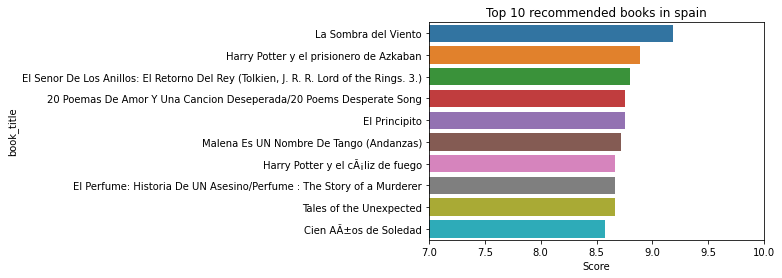

In [23]:
country_from_user = input('Type a country:')
suggest_top_10_books_by_country(country_from_user)

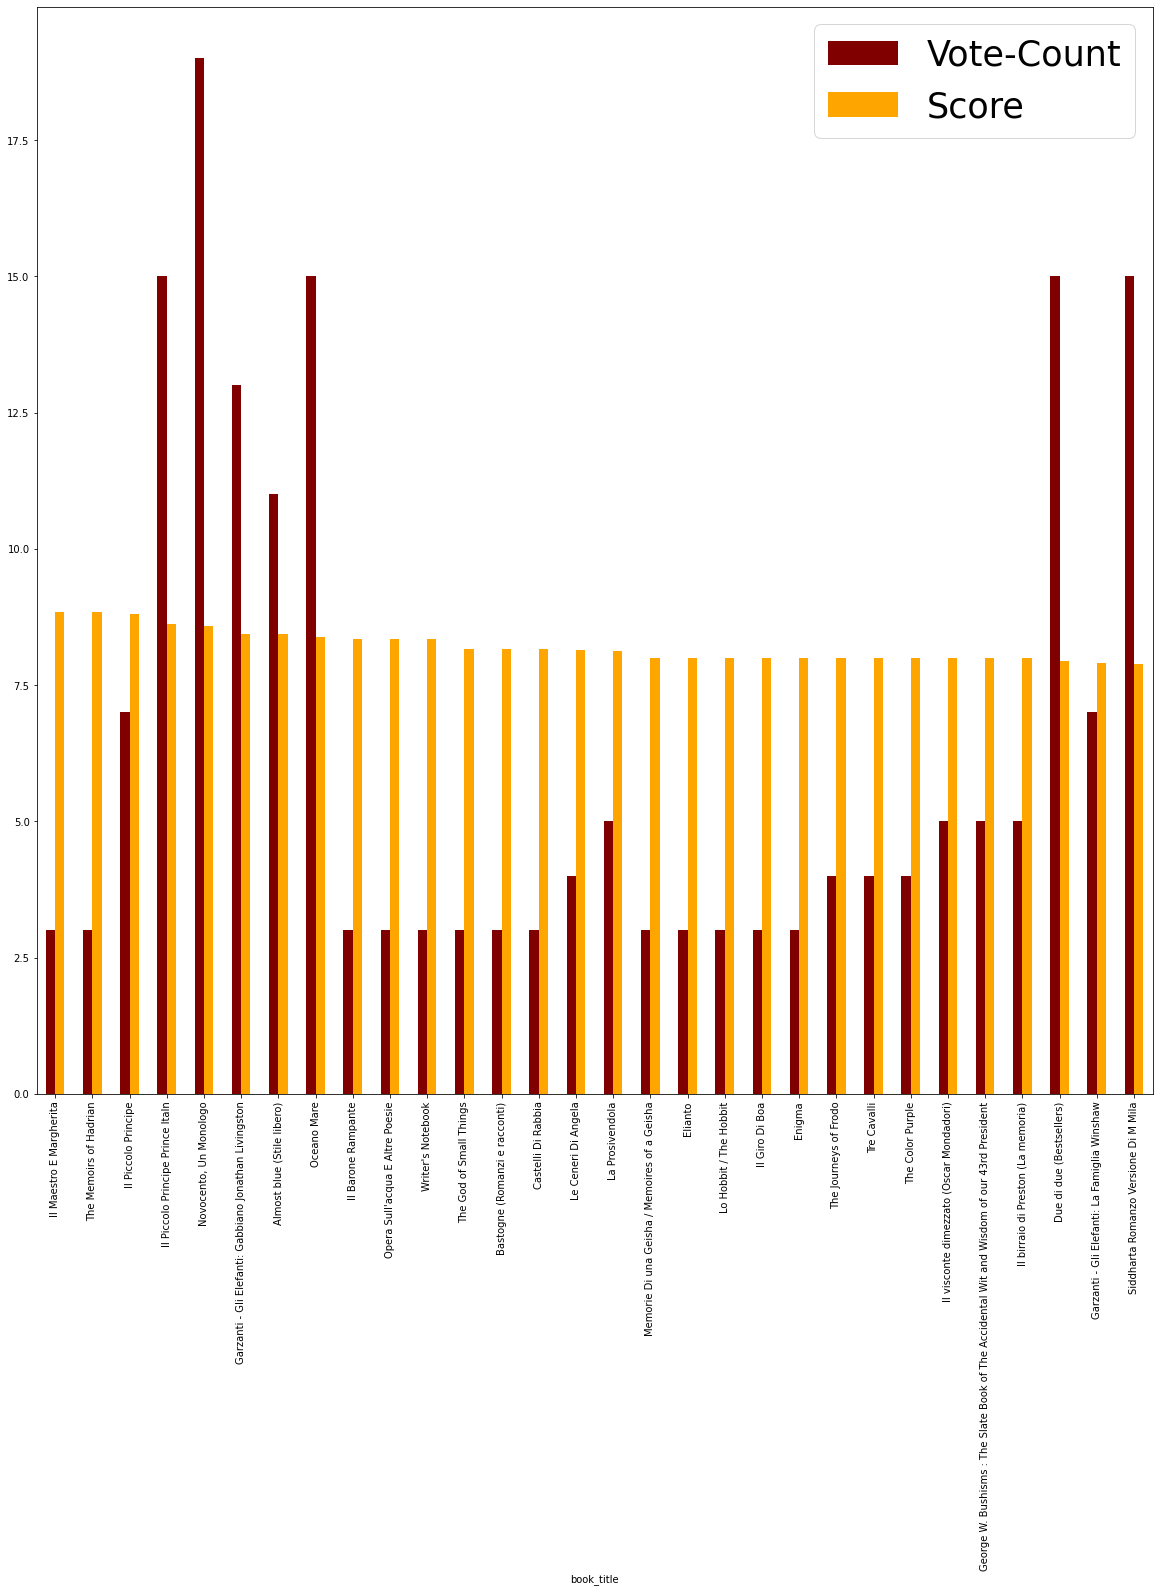

In [24]:
## Took Italy as an example.
italy_df = df_rating_bycountry[df_rating_bycountry["country"] == 'italy']
italy_df =italy_df.sort_values('Score', ascending=False)
top_30_italy= italy_df.head(30)
top_30_italy.plot.bar(x='book_title', y=['Vote-Count','Score'], color=['maroon','orange'],figsize=(20,20))
plt.legend(['Vote-Count', 'Score'], fontsize = 35)

------------------------------------------------------------------------
# Content Filtering

### Plot description based Recommender

In [25]:
df = pd.read_csv('Preprocessed_data_cleaned.csv')
df = df[df['Language'] == 'en']
df=df.drop(columns=['Unnamed: 0', 'user_id','age','rating','book_author','year_of_publication','Category','city','Language','state','country','location','publisher'])
df

,isbn,book_title,Summary
0,0002005018,Clara Callan,"In a small town in Canada, Clara Callan reluct..."
1,0002005018,Clara Callan,"In a small town in Canada, Clara Callan reluct..."
2,0002005018,Clara Callan,"In a small town in Canada, Clara Callan reluct..."
3,0002005018,Clara Callan,"In a small town in Canada, Clara Callan reluct..."
4,0002005018,Clara Callan,"In a small town in Canada, Clara Callan reluct..."
...,...,...,...
359463,0670528951,Orson Welles,"Based on two years of interviews and research,..."
359464,0689818904,My Grandmother's Journey,A grandmother tells the story of her eventful ...
359466,067161746X,The Bachelor Home Companion: A Practical Guide...,A tongue-in-cheek survival guide for single pe...
359467,0767907566,All Elevations Unknown: An Adventure in the He...,A daring twist on the travel-adventure genre t...


In [26]:
##Clearing out the books and summaries that appear more than once in the dataframe
df =df.drop_duplicates(subset='isbn', keep='first')
df =df.drop_duplicates(subset='Summary', keep='first')
df['Summary'] = df['Summary'].fillna('')
df=df.reset_index(drop=True)
df

,isbn,book_title,Summary
0,0002005018,Clara Callan,"In a small town in Canada, Clara Callan reluct..."
1,0060973129,Decision in Normandy,"Here, for the first time in paperback, is an o..."
2,0374157065,Flu: The Story of the Great Influenza Pandemic...,"Describes the great flu epidemic of 1918, an o..."
3,0399135782,The Kitchen God's Wife,A Chinese immigrant who is convinced she is dy...
4,0425176428,What If?: The World's Foremost Military Histor...,"Essays by respected military historians, inclu..."
...,...,...,...
73861,0670528951,Orson Welles,"Based on two years of interviews and research,..."
73862,0689818904,My Grandmother's Journey,A grandmother tells the story of her eventful ...
73863,067161746X,The Bachelor Home Companion: A Practical Guide...,A tongue-in-cheek survival guide for single pe...
73864,0767907566,All Elevations Unknown: An Adventure in the He...,A daring twist on the travel-adventure genre t...


In [27]:
stop_words = set(stopwords.words('english'))
## takes str as input and cleans it of punctuation etc
def cleaner(aString):
    output = aString.lower()
    remove_punctuation=re.sub(r'[^\w\s]', '',  output)
    remove_back=re.sub(r'[0-9]',"",remove_punctuation) 
    remove_back=re.sub(r'[\n]'," ",remove_back) 
    text_tokens = word_tokenize(remove_back)
    str_no_stopw = [word for word in text_tokens if not word in stop_words]
    summary= (" ").join(str_no_stopw)
    return summary

In [28]:
##cleans the summaries of the books
df['Summary']=list(map(lambda x: cleaner(x),df['Summary']))

In [29]:
# Remove str reference
del str

In [30]:
def Jaccard_Similarity(str1, str2): 
    str1 = str(str1)
    str2 = str(str2)

    # List the unique words in a document
    set1 = set(str1.split()) 
    set2 = set(str2.split())
    
    # Finds intersection os strings
    intersection = set1.intersection(set2)

    # Finds union of words of strings
    union = set1.union(set2)
        
    # Calculate Jaccard score  add reference Mining of Massive Datasets Book page 74 Chapter 3
    return float(len(intersection)) / len(union)

In [31]:
def get_recommendations(title, column):
    
    # Get the index of the book that matches the title
    idx = df[df['book_title']==title].index.values[0]

    # calculate the jaccard similarity of all books with that book
    Jaccard_score = list(map(lambda x: Jaccard_Similarity(x,df[column][idx]),df[column]))
    
    Jaccard_score_df = pd.DataFrame(Jaccard_score,columns =['Similarity_Score'])
    
    Jaccard_score_df = pd.merge(Jaccard_score_df, df, left_index=True, right_index=True)
    
    # Sort the books based on the similarity scores
    Jaccard_score_df = Jaccard_score_df.sort_values('Similarity_Score', ascending=False)
    
    # Get the scores of the 10 most similar books
    Jaccard_score_df = Jaccard_score_df[1:11]
    Jaccard_score_df = pd.DataFrame(Jaccard_score_df)
    Jaccard_score_df= Jaccard_score_df.reset_index(drop= True)

    # Return the top 10 most similar books
    return Jaccard_score_df
#Jaccard_score_df['book_title']

Let's take as an example the Book "Decision in Normandy".

,Similarity_Score,isbn,book_title,Summary
0,0.166667,1853673110,War on the Eastern Front: The German Soldier i...,first time paperback lucas details experiences...
1,0.125000,0060554886,The Illustrator in America : 1860-2000,first published revised third edition offered ...
2,0.120000,0140235426,Six Armies in Normandy: From D-Day to the Libe...,recreates military accomplishments delineates ...
3,0.115385,0864923732,"Saint John Fortifications, 1630-1956 (New Brun...",saint john fortifications first volume new bru...
4,0.115385,0385126514,For Her Own Good : 150 Years of the Experts' A...,provocative new perspective female history his...
5,0.114286,0590021117,Little House On the Prairie,first time history little house books new edit...
6,0.114286,0520201663,The Collected Poems of Frank O'Hara,available first time paperback collected poems...
7,0.114286,0060581859,The Long Winter (Little House),first time history little house books new edit...
8,0.114286,0590300946,Long Winter,first time history little house books new edit...
9,0.111111,0226718530,Readings in Russian Civilization: Russian Befo...,first volume undergone least change new items ...


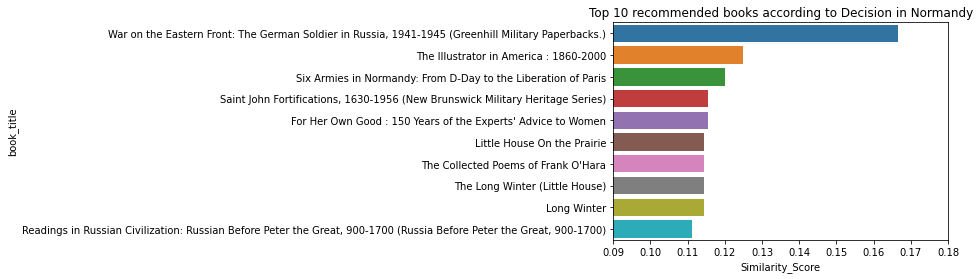

In [32]:
Jaccard_recommendation_df = get_recommendations("Decision in Normandy", "Summary")
sb.barplot(x = "Similarity_Score", y = "book_title", data = Jaccard_recommendation_df).set(title = "Top 10 recommended books according to Decision in Normandy", xlim=(0.09,0.18))
Jaccard_recommendation_df

In [33]:
def interactive_content_recommendation(book_title_from_user, column):
    if book_title_from_user in list(df['book_title']):
        Jaccard_recommendation_df = get_recommendations(book_title_from_user, column)
        sb.barplot(x = "Similarity_Score", y = "book_title", data = Jaccard_recommendation_df).set(title = f"Top 10 recommended books according to {book_title_from_user}")
       
    else:
        pd.options.display.max_colwidth = 100
        print(f'Book not in the list, please choose- copy & paste- one of the following -10 random examples-:\n{df["book_title"].sample(n=10)}')
        book_title_from_user = input('Type a book title:')
        interactive_content_recommendation(book_title_from_user, column)
    return


Book not in the list, please choose- copy & paste- one of the following -10 random examples-:
73778    The Riverside Anthology of Literature, Third Edition
48349                 Tough Luck (Vintage Crime/Black Lizard)
26113                                  That Fine Italian Hand
54172                                             Bloodhounds
7150                                        Arrows of the Sun
30716              Deus Io Volt!: A Chronicle of the Crusades
24698                         Amazing but True Sports Stories
40696          Terra sonÃ¢mbula: Romance (Uma Terra sem amos)
70098             Owls and Other Fantasies : Poems and Essays
20192              Final Fantasy VIII Official Strategy Guide
Name: book_title, dtype: object
Type a book title:Bloodhounds


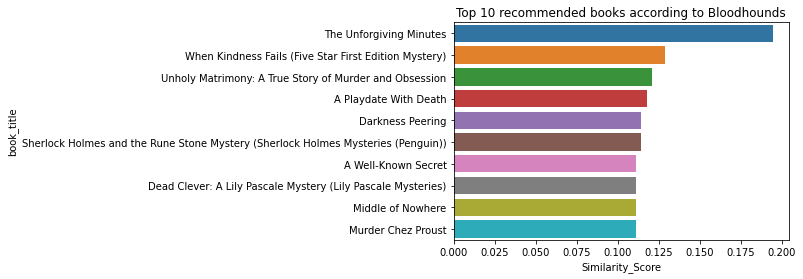

In [34]:
title_from_user = input()
interactive_content_recommendation(title_from_user, "Summary")

### Variable based Recommender (book_title, book_author, publisher and Category)

In [43]:
df = pd.read_csv('Preprocessed_data_cleaned.csv')
df = df[df['Language'] == 'en']
df=df.drop(columns=['Unnamed: 0', 'user_id','age','rating','year_of_publication','city','Language','state','country','location'])
##Clearing out the books and summaries that appear more than once in the dataframe
df =df.drop_duplicates(subset='isbn', keep='first')
df =df.drop_duplicates(subset='Summary', keep='first')
df['Summary'] = df['Summary'].fillna('')
df=df.reset_index(drop=True)
df

,isbn,book_title,book_author,publisher,Summary,Category
0,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,"In a small town in Canada, Clara Callan reluctantly takes leave of her\r\nsister, Nora, who is b...",['Actresses']
1,0060973129,Decision in Normandy,Carlo D'Este,HarperPerennial,"Here, for the first time in paperback, is an outstanding military\r\nhistory that offers a drama...",['1940-1949']
2,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,Farrar Straus Giroux,"Describes the great flu epidemic of 1918, an outbreak that killed some\r\nforty million people w...",['Medical']
3,0399135782,The Kitchen God's Wife,Amy Tan,Putnam Pub Group,A Chinese immigrant who is convinced she is dying threatens to\r\ncelebrate the Chinese New Year...,['Fiction']
4,0425176428,What If?: The World's Foremost Military Historians Imagine What Might Have Been,Robert Cowley,Berkley Publishing Group,"Essays by respected military historians, including Stephen Ambrose,\r\nDavid McCullough, James M...",['History']
...,...,...,...,...,...,...
73861,0670528951,Orson Welles,Barbara Leaming,Penguin USA,"Based on two years of interviews and research, this biography portrays\r\nthe flamboyant America...",['Biography & Autobiography']
73862,0689818904,My Grandmother's Journey,John Cech,Aladdin,A grandmother tells the story of her eventful life in early twentieth-\r\ncentury Europe and her...,['Juvenile Fiction']
73863,067161746X,The Bachelor Home Companion: A Practical Guide to Keeping House Like a Pig,P.J. O'Rourke,Pocket Books,A tongue-in-cheek survival guide for single people reveals the\r\nquintessential secrets of no-f...,['Humor']
73864,0767907566,All Elevations Unknown: An Adventure in the Heart of Borneo,Sam Lightner,Broadway Books,A daring twist on the travel-adventure genre that places the talented\r\nLightner in the ranks o...,['Nature']


In [44]:
# Data analysis
features = ['book_title', 'book_author', 'publisher', 'Category']
analysis_filename = 'data_analysis.txt'

for current_feature in features:
    unique_values = df[current_feature].unique().tolist()

    with open(f"{analysis_filename}_{current_feature}", 'w', encoding="utf-8") as f:
        for v in unique_values:
            f.write("%s\n" % v)

# See how common each category is
print(df[features[3]].value_counts())


# Current features head
df[features].head()

['Fiction']                                               30332
['Juvenile Fiction']                                       5296
['Biography & Autobiography']                              3090
['History']                                                1782
['Religion']                                               1715
                                                          ...  
['Afrikaners']                                                1
['Fugitives from justice']                                    1
['Midlife crisis']                                            1
['Maigret, Jules (Fictitious character)']                     1
['Authors, Canadian (English) 20th century Biography']        1
Name: Category, Length: 3745, dtype: int64


,book_title,book_author,publisher,Category
0,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,['Actresses']
1,Decision in Normandy,Carlo D'Este,HarperPerennial,['1940-1949']
2,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,Farrar Straus Giroux,['Medical']
3,The Kitchen God's Wife,Amy Tan,Putnam Pub Group,['Fiction']
4,What If?: The World's Foremost Military Historians Imagine What Might Have Been,Robert Cowley,Berkley Publishing Group,['History']


In [45]:
# Clean 'category column'
from ast import literal_eval

features = ['book_title', 'book_author', 'publisher', 'Category']

# Parse the stringified features into their corresponding python objects
df[features[3]] = df[features[3]].apply(literal_eval)

# Since each list contains only 1 element, replace the list by the element inside while dealing
# with the 9 values
def get_str_from_list(val):
    if val == 9:
        return "9"
    return val[0]

df[features[3]] = df[features[3]].apply(get_str_from_list)

# Current features head
df[features].head()

,book_title,book_author,publisher,Category
0,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,Actresses
1,Decision in Normandy,Carlo D'Este,HarperPerennial,1940-1949
2,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,Farrar Straus Giroux,Medical
3,The Kitchen God's Wife,Amy Tan,Putnam Pub Group,Fiction
4,What If?: The World's Foremost Military Historians Imagine What Might Have Been,Robert Cowley,Berkley Publishing Group,History


In [46]:
# Function to convert all strings to lower case and strip names of spaces
def lower_and_remove_spaces(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if author exists. If not, return empty string
        if isinstance(x, str):
            return x.replace(" ", "").lower()
        else:
            return ''

def lower(x):
    return x.lower()


# Apply clean_data function to selected features.
remove_spaces_features = ['book_author', 'publisher']

for feature in remove_spaces_features:
    df[feature] = df[feature].apply(lower_and_remove_spaces)

for feature in features:
    df[feature] = df[feature].apply(lower)


# Current features head
df[features].head()

,book_title,book_author,publisher,Category
0,clara callan,richardbrucewright,harperflamingocanada,actresses
1,decision in normandy,carlod'este,harperperennial,1940-1949
2,flu: the story of the great influenza pandemic of 1918 and the search for the virus that caused it,ginabarikolata,farrarstrausgiroux,medical
3,the kitchen god's wife,amytan,putnampubgroup,fiction
4,what if?: the world's foremost military historians imagine what might have been,robertcowley,berkleypublishinggroup,history


In [47]:
# Start recommender system

def create_soup(x):
    return x[features[0]] + ' ' + x[features[1]] + ' ' + x[features[2]] + ' ' + x[features[3]]
df['soup'] = df.apply(create_soup, axis=1)

print(df['soup'].head())

0                                         clara callan richardbrucewright harperflamingocanada actresses
1                                             decision in normandy carlod'este harperperennial 1940-1949
2    flu: the story of the great influenza pandemic of 1918 and the search for the virus that caused ...
3                                                   the kitchen god's wife amytan putnampubgroup fiction
4    what if?: the world's foremost military historians imagine what might have been robertcowley ber...
Name: soup, dtype: object


In [48]:
# Show what the current soup for the first book look like
print(df['soup'][0])
print(df['book_title'][0])

clara callan richardbrucewright harperflamingocanada actresses
clara callan


In [51]:
jaccard_score_df = get_recommendations("decision in normandy", "soup")
jaccard_score_df

,Similarity_Score,isbn,book_title,book_author,publisher,Summary,Category,soup
0,0.133333,0345346521,decision in philadelphia: the constitutional convention of 1787,christophercollier,ballantinebooks,Draws on the latest research and scholarly thinking to reconstruct the\r\npersonality and ideolo...,history,decision in philadelphia: the constitutional convention of 1787 christophercollier ballantineboo...
1,0.117647,0029227909,thinking in time (the uses of history for decision makers),richardeneustadt,colliermacmillan,Provides a process and framework for using historical knowledge in\r\nintelligent decision makin...,decision-making,thinking in time (the uses of history for decision makers) richardeneustadt colliermacmillan dec...
2,0.100000,0892760524,in him,kennethe.hagin,faithlibrarypublications,This minibook will help believers learn more about who they are and\r\nwhat they have in Christ.,confession,in him kennethe.hagin faithlibrarypublications confession
3,0.100000,0061000671,emerald decision,craigthomas,harpermassmarketpaperbacks(mm),"While in Germany to research his new book, American writer Thomas\r\nMcBride uncovers a deadly f...",fiction,emerald decision craigthomas harpermassmarketpaperbacks(mm) fiction
4,0.100000,0394430387,in touch,johnsteinbeckiv,randomhouseinc,"John Steinbeck IV reveals his views on America in 1966, when he was\r\n21, as he writes of Vietn...",marijuana.,in touch johnsteinbeckiv randomhouseinc marijuana.
5,0.100000,0880011254,eating in,bettyharperfussell,wwnorton&coinc,"Gathers quick recipes for appetizers, pasta, seafood, fish, poultry,\r\nmeat, eggs, soup, rice, ...",cooking,eating in bettyharperfussell wwnorton&coinc cooking
6,0.100000,0449207552,break in,dickfrancis,fawcettbooks,"Successful steeplechase jockey Christmas &quot;Kit&quot; Fielding\r\nfinds himself attacked, cha...",fiction,break in dickfrancis fawcettbooks fiction
7,0.100000,0060806982,profiles in courage,johnf.kennedy,perennial,&quot;This is a book about the most admirable of human virtues--\r\ncourage.,courage,profiles in courage johnf.kennedy perennial courage
8,0.100000,0060809590,in country,bobbieannmason,harpercollinspublisher,"Vietnam&#39;s moral fallout is revealed to &quot;Sam&quot; Hughes, an\r\neighteen-year-old Kentu...",fiction,in country bobbieannmason harpercollinspublisher fiction
9,0.100000,0778320243,in confidence,karenyoung,mirabooks,High school guidance counselor Rachel Forrester comes to terms with\r\nthe new direction in her ...,fiction,in confidence karenyoung mirabooks fiction


[Text(0.5, 1.0, 'Top 10 recommended books according to Decision in Normandy')]

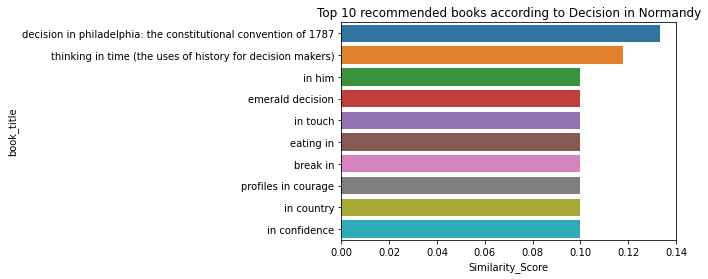

In [52]:
sb.barplot(x = "Similarity_Score", y = "book_title", data = jaccard_score_df).set(title = "Top 10 recommended books according to Decision in Normandy")
